# Hierarchical attention network for documents classification

## Import libraries

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras.backend as K
from keras.preprocessing import text, sequence
from keras.preprocessing.text import Tokenizer
from keras.layers import Layer
from keras import initializers, regularizers, constraints
from keras.layers import *
from keras.models import Model


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/My Drive/Document-classification

/content/drive/My Drive/Document-classification


## Load data

In [6]:
MAX_WORDS = 50
MAX_SENTENCES = 30

def get_data(filename):
  data = []
  labels = []
  with open(filename) as f:
      for data_id, line in enumerate(f):
        features = line.split('<fff>')
        label, doc_id, content = int(features[0]), int(features[1]), features[2:]
        labels.append(label)
        encoded_contents = [] 
        
        for sentence in content:
            encoded_sentences = [int(token) for token in sentence.split()]
            encoded_contents.append(encoded_sentences)
        data.append(encoded_contents)
  return np.array(data), np.array(labels)


In [8]:
X_train, y_train = get_data('20news-train-encoded.txt')

In [9]:
X_test, y_test = get_data('20news-test-encoded.txt')

In [19]:
y_train = pd.get_dummies(pd.Series(y_train)).values
y_test = pd.get_dummies(pd.Series(y_test)).values


In [10]:
with open("vocab-raw.txt", 'rb') as f:
  vocab_size = len(f.read().splitlines())
vocab_size

18988

## Define attention layer

In [11]:
def dot_product(x, kernel):
    """
    Wrapper for dot product operation, in order to be compatible with both
    Theano and Tensorflow
    Args:
        x (): input
        kernel (): weights
    Returns:
    """
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)


In [12]:
class AttentionWithContext(tf.keras.layers.Layer):
    
    def __init__(self,
                 W_regularizer=None, u_regularizer=None, b_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True, **kwargs):

        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        super(AttentionWithContext, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight(shape=(input_shape[-1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)

        self.u = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint)

        super(AttentionWithContext, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        uit = dot_product(x, self.W)

        if self.bias:
            uit += self.b

        uit = K.tanh(uit)
        ait = dot_product(uit, self.u)

        a = K.exp(ait)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]


## Model

In [21]:
embedding_layer = Embedding(input_dim=vocab_size+2, output_dim=300, input_length=MAX_WORDS)

char_input = Input(shape=(MAX_WORDS,), dtype='int32')
char_sequences = embedding_layer(char_input)
char_lstm = Bidirectional(LSTM(100, return_sequences=True))(char_sequences)
char_dense = TimeDistributed(Dense(200))(char_lstm)
char_att = AttentionWithContext()(char_dense)
charEncoder = Model(char_input, char_att)

words_input = Input(shape=(MAX_SENTENCES, MAX_WORDS), dtype='int32')
words_encoder = TimeDistributed(charEncoder)(words_input)
words_lstm = Bidirectional(LSTM(100, return_sequences=True))(words_encoder)
words_dense = TimeDistributed(Dense(200))(words_lstm)
words_att = AttentionWithContext()(words_dense)
preds = Dense(20, activation='softmax')(words_att)
model = Model(words_input, preds)

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 30, 50)]          0         
                                                                 
 time_distributed_7 (TimeDis  (None, 30, 200)          6098400   
 tributed)                                                       
                                                                 
 bidirectional_5 (Bidirectio  (None, 30, 200)          240800    
 nal)                                                            
                                                                 
 time_distributed_8 (TimeDis  (None, 30, 200)          40200     
 tributed)                                                       
                                                                 
 attention_with_context_5 (A  (None, 200)              40400     
 ttentionWithContext)                                      

In [24]:
history = model.fit(X_train, y_train,
                    epochs=10, verbose=1,
                    validation_split = 0.1,
                    batch_size= 100, shuffle = True)


Epoch 1/10
102/102 [==============================] - 22s 216ms/step - loss: 0.1463 - acc: 0.9600 - val_loss: 8.8833 - val_acc: 0.1890
Epoch 2/10
102/102 [==============================] - 23s 222ms/step - loss: 0.0180 - acc: 0.9950 - val_loss: 9.6058 - val_acc: 0.2138
Epoch 3/10
102/102 [==============================] - 22s 213ms/step - loss: 0.0051 - acc: 0.9989 - val_loss: 9.6628 - val_acc: 0.2155
Epoch 4/10
102/102 [==============================] - 21s 210ms/step - loss: 0.0018 - acc: 0.9994 - val_loss: 9.9151 - val_acc: 0.2147
Epoch 5/10
102/102 [==============================] - 22s 213ms/step - loss: 0.0018 - acc: 0.9995 - val_loss: 10.0868 - val_acc: 0.2138
Epoch 6/10
102/102 [==============================] - 22s 216ms/step - loss: 0.0014 - acc: 0.9995 - val_loss: 10.2441 - val_acc: 0.2147
Epoch 7/10
102/102 [==============================] - 22s 213ms/step - loss: 0.0014 - acc: 0.9995 - val_loss: 10.2302 - val_acc: 0.2173
Epoch 8/10
102/102 [==============================] 

In [25]:
model.evaluate(X_test, y_test)

236/236 [==============================] - 6s 26ms/step - loss: 2.0300 - acc: 0.7593


[2.0299768447875977, 0.7592936754226685]

In [30]:
from matplotlib import pyplot as plt
 
def summarize_diagnostics(history, model_name):

    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title(f'{model_name} accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{model_name} loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()


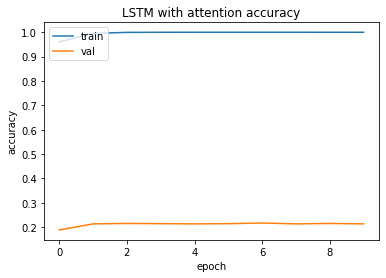

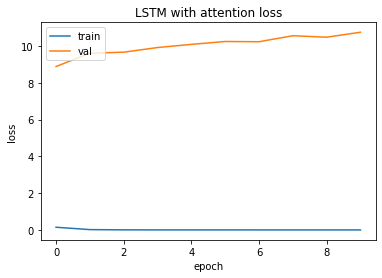

In [31]:
summarize_diagnostics(history, "LSTM with attention")